In [84]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd


from loading_utils import * 
from plotting_utils import * 

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'

In [85]:
import os

import pandas as pd
import numpy as np
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
#plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

In [152]:
scen_labels_     = pd.read_csv('cost_scenario_labels.csv') 
tech_labels_     = pd.read_csv('technology_labels.csv') 
dispatch_labels_ = pd.read_csv('dispatch_labels.csv') 

In [153]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_, path):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(capacity_, projects_, scenario, zone):

        capacity_['capacity_mw'] = capacity_['capacity_mw'].astype(float)
        capacity_['Status']      = 'new'

        for project in projects_['project'].unique():
            if capacity_.loc[(capacity_['project'] == project) & (capacity_['period'] == 2020), 'capacity_mw'].to_numpy()[0] != 0.:
                capacity_.loc[capacity_['project'] == project, 'Status'] = 'existing'

        periods_ = capacity_['period'].unique()
        techs_   = capacity_['technology'].unique()
        status_  = capacity_['Status'].unique()

        capacity_all_ = []

        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                for status, i_status in zip(status_, range(len(status_))):

                    # Find specific row from database
                    if zone == 'all':
                        idx_ = (capacity_['period'] == period) & (capacity_['technology'] == tech) & (capacity_['Status'] == status)
                    else:
                        idx_ = (capacity_['period'] == period) & (capacity_['technology'] == tech) & (capacity_['Status'] == status) & (capacity_['load_zone'] == zone)

                    capacity_all_ += [[scenario,
                                       period,
                                       tech,
                                       zone,
                                       status,
                                       np.sum(capacity_.loc[idx_, 'capacity_mw']),
                                       np.sum(capacity_.loc[idx_, 'energy_capacity_mwh'])]]

        return pd.DataFrame(np.array(capacity_all_), columns = ['Scenario', 'Period', 'Technology', 'Zone', 'Status', 'Power', 'Energy']).sort_values(by = ['Scenario', 'Period', 'Technology', 'Zone']).reset_index(drop = True)

    scenarios_ = scen_labels_['scenario'].to_list()
    zones_     = scen_labels_['zone'].to_list()
    dfs_       = []

    # Open connection: open database and grab meta-data
    for scenario, zone in zip(scenarios_, zones_):
        print(scenario, zone)
        dir_name        = r'{}/{}'.format(path, scenario)
        capacity_table_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        spec_table_     = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_table_  = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        project_table_  = project_table_[project_table_['project'].isin(pd.unique(spec_table_['project']))]
        df_             = __load_new_and_existing_csv(capacity_table_, project_table_, scenario, zone)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    dfs_           = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    dfs_['Power']  = dfs_['Power'].astype(float)
    dfs_['Energy'] = dfs_['Energy'].astype(float)
    dfs_['Period'] = dfs_['Period'].astype(int)
    
    return dfs_[['Scenario', 'Period', 'Technology', 'Zone', 'Status', 'Power', 'Energy']]

def _group_capacity_technologies(capacity_all_, tech_labels_):

    def __agg(df_, row_, x_):
        idx_  = df_['Technology'].isin(x_)
        row_ += [df_.loc[idx_, 'Power'].sum(), df_.loc[idx_, 'Energy'].sum()]
        df_   = df_.drop(df_.index.values[idx_])
        df_   = df_.reset_index(drop = True)
        df_.loc[len(df_.index)] = row_
        return df_

    groups_ = tech_labels_['group'].unique()

    dfs_ = []
    for scenario in capacity_all_['Scenario'].unique():
        for period in capacity_all_['Period'].unique():
            for zone in capacity_all_['Zone'].unique():
                for status in capacity_all_['Status'].unique():
                    idx_ = (capacity_all_['Scenario'] == scenario) & (capacity_all_['Period'] == period) & (capacity_all_['Zone'] == zone) & (capacity_all_['Status'] == status)
                    df_  = capacity_all_.loc[idx_]
                    for group in groups_:
                        techs_ = tech_labels_.loc[tech_labels_['group'] == group, 'technology'].to_list()
                        df_    = __agg(df_, [scenario, period, group, zone, status], techs_)
                    dfs_.append(df_)
    return pd.concat(dfs_).sort_values(by = ['Scenario', 'Period', 'Technology', 'Zone']).reset_index(drop = True)


In [154]:
path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios/cost'

scenarios_ = scen_labels_['scenario'].to_list()
zones_     = scen_labels_['zone'].to_list()

capacity_ = _load_capacity(scen_labels_, path_to_scenarios)
grouped_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)


VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all


In [155]:
def _plot_new_and_existing_capacity(data_, scens_label_, tech_label_,
                                    units        = 1e3,
                                    units_label  = '(GW)',
                                    y_period     = 0.,
                                    y_grid_inc   = 500,
                                    div_line_len = 0.,
                                    save         = True,
                                    legend       = True,
                                    title        = '',
                                    file_name    = 'noname.pdf'):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['Technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'Power'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)

    scens_  = scens_label_['scenario'].to_list()
    labels_ = scens_label_['label'].to_list()
    zones_  = scens_label_['zone'].to_list()

    periods_ = np.sort(data_['Period'].unique())

    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()


    offset = 0.
    y_max  = 0
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    fig = plt.figure(figsize = (12.5, 10))
    ax  = plt.subplot(111)

    ticks_        = []
    ticks_labels_ = []
    ticks_labels_length_ = []

    offsets_  = []
    lengths_  = []
    x_period_ = []
    for scen, i_scen in zip(scens_, range(len(scens_))):

        zone = zones_[i_scen]

        df_ = data_.loc[data_['Zone'] == zone].sort_values(by = ['Period'])

        lengths_.append(len(scen))
        for period, i_period in zip(periods_, range(len(periods_))):
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_ = (df_['Zone'] == zone) & (df_['Period'] == period)
                idx_ = idx_ & (df_['Scenario'] == scen) & (df_['Technology'] == tech)
                idx_ = idx_ & (df_['Status'] == 'existing')

                if idx_.sum() == 1.:
                    power = df_.loc[idx_, 'Power'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'] .unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_ = (df_['Zone'] == zone) & (df_['Period'] == period) & (df_['Scenario'] == scen)
                idx_ = idx_ & (df_['Technology'] == tech) & (df_['Status'] == 'new')

                if idx_.sum() == 1.:
                    power = df_.loc[idx_, 'Power'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'] .unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            ticks_labels_.append('{}'.format(labels_[i_scen]))
            offsets_.append(offset/units)

            ticks_labels_length_.append(len(ticks_labels_[-1]))


            offset = 0.

            x_period_.append(x_[i_period])


        x_ = x_ + .9/len(scens_)
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        plt.text(x_period, (0.05*y_period_[-1] + y_period), '{}'.format(period), fontsize            = 18, 
                                                                                 weight              = 'bold',
                                                                                 horizontalalignment = 'center', 
                                                                                 verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = div_line_len,
                              ymax      = 0.,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, ticks_labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    plt.ylim(-10., y_period_.max()*1.2)

    plt.title(title, fontsize = 20,
                     y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    plt.grid(axis = 'y')

    if save:
        plt.savefig(file_name, bbox_inches = 'tight', dpi = 600)
        plt.show()


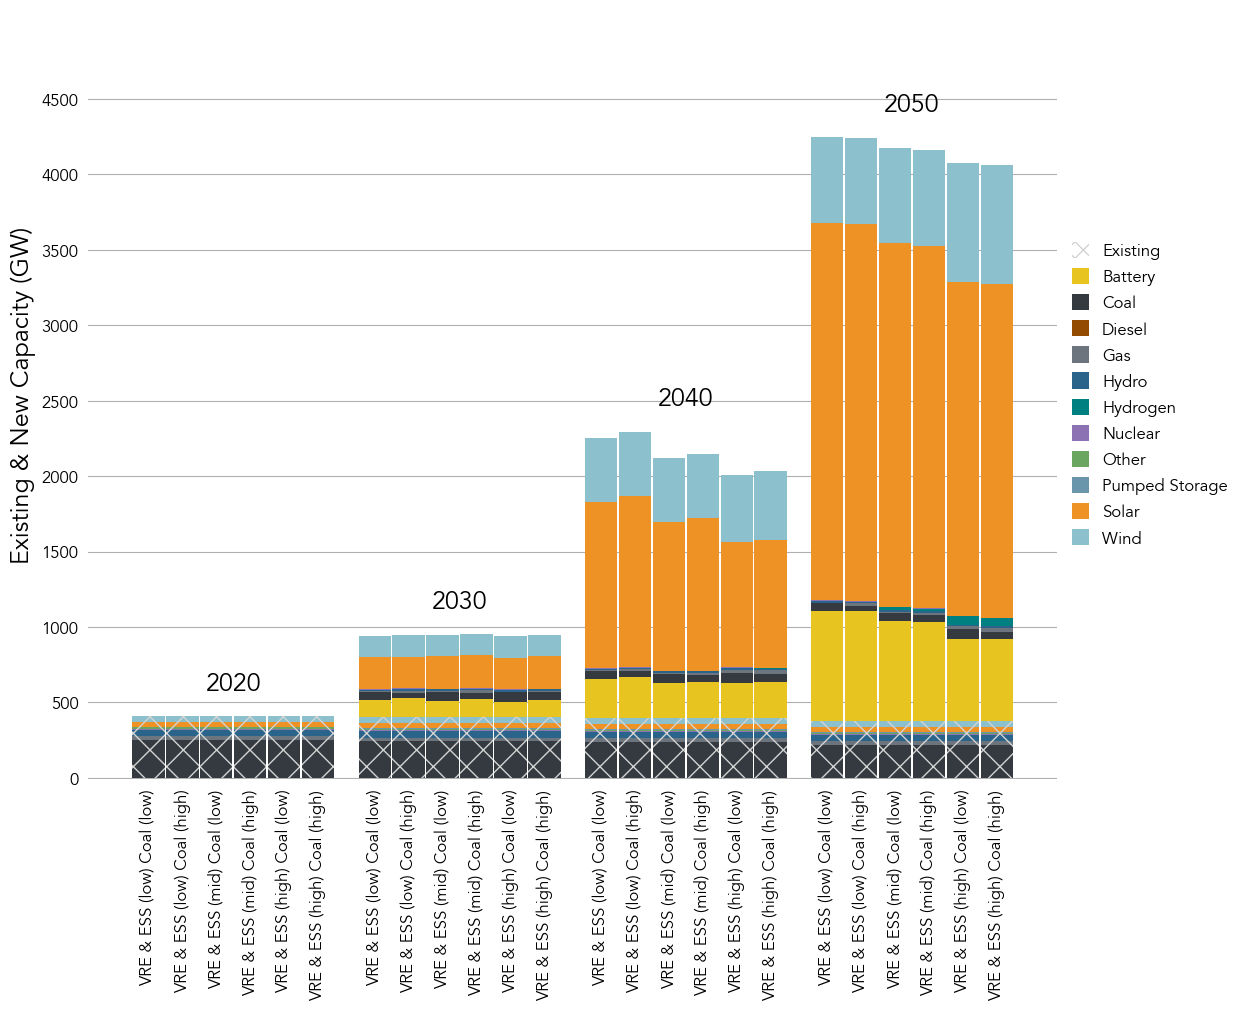

In [156]:
_plot_new_and_existing_capacity(grouped_capacity_, scen_labels_, tech_labels_,
                                units        = 1e3,
                                units_label  = 'Existing & New Capacity (GW)',
                                legend       = True,
                                save         = True,
                                y_grid_inc   = 500,
                                title        = '',
                                file_name    = path_to_images + r'/group_installed_capacity.png')

In [138]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_energy_dispatch(scen_labels_, path):

    # Load energy dispatch table and process data from database
    def __load_ed_from_csv(ed_, scenario, zone):
        
        periods_  = ed_['period'].unique()
        techs_    = ed_['technology'].unique()
        dispatch_ = []
        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                # Find specific row from database 
                if zone == 'all':
                    idx_ = (ed_['period'] == period) & (ed_['technology'] == tech)
                else:
                    idx_ = (ed_['period'] == period) & (ed_['technology'] == tech) & (ed_['load_zone'] == zone)

                dispatch_ += [[scenario, 
                               period, 
                               tech, 
                               zone, 
                               np.sum(ed_.loc[idx_, 'number_of_hours_in_timepoint']*ed_.loc[idx_, 'timepoint_weight']*ed_.loc[idx_, 'power_mw'])]]

        return pd.DataFrame(np.array(dispatch_), columns = ['Scenario', 'Period', 'Technology', 'Zone', 'Energy'])

    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(table_, scenario, zone):
        
        periods_ = table_['period'].unique()
        demand_  = []
        for period, i_period in zip(periods_, range(len(periods_))):
            # Find specific row from database 
            if zone == 'all':
                idx_ = (table_['period'] == period)
            else:
                idx_ = (table_['period'] == period) & (table_['load_zone'] == zone)

            demand_ += [[scenario, 
                         period, 
                         'Shedding', 
                         zone, 
                         np.sum(table_.loc[idx_, 'number_of_hours_in_timepoint']*table_.loc[idx_, 'timepoint_weight']*table_.loc[idx_, 'unserved_energy_mw'])]]

            demand_ += [[scenario, 
                         period, 
                         'Curtailment', 
                         zone, 
                         np.sum(table_.loc[idx_, 'number_of_hours_in_timepoint']*table_.loc[idx_, 'timepoint_weight']*table_.loc[idx_, 'overgeneration_mw'])]]

        return pd.DataFrame(np.array(demand_), columns = ['Scenario', 'Period', 'Technology', 'Zone', 'Energy'])

    def _load_tx_losses_from_csv(table_, scenario, zone):
        
        periods_ = table_['period'].unique()
        df_  = []
        for period, i_period in zip(periods_, range(len(periods_))):
            # Find specific row from database 
            if zone == 'all':
                idx_ = (table_['period'] == period)
            else:
                idx_ = (table_['period'] == period) & (table_['load_zone_to'] == zone)

            df_ += [[scenario, period, 'Tx_Losses', zone, 
                     -np.sum(table_.loc[idx_, 'number_of_hours_in_timepoint']*table_.loc[idx_, 'timepoint_weight']*table_.loc[idx_, 'transmission_losses_lz_to'])]]
            
            if zone != 'all':

                idx_ = idx_ & (table_.loc[idx_, 'transmission_flow_mw'] > 0)
                df_ += [[scenario, period, 'Import', zone, 
                         np.sum(table_.loc[idx_, 'number_of_hours_in_timepoint']*table_.loc[idx_, 'timepoint_weight']*table_.loc[idx_, 'transmission_flow_mw'])]]

                idx_ = idx_ & (table_.loc[idx_, 'transmission_flow_mw'] < 0)
                df_ += [[scenario, period, 'Export', zone, 
                         np.sum(table_.loc[idx_, 'number_of_hours_in_timepoint']*table_.loc[idx_, 'timepoint_weight']*table_.loc[idx_, 'transmission_flow_mw'])]]

        return pd.DataFrame(np.array(df_), columns = ['Scenario', 'Period', 'Technology', 'Zone', 'Energy'])
        
    scenarios_ = scen_labels_['scenario'].to_list()
    zones_     = scen_labels_['zone'].to_list()
    dfs_       = []
    # Open connection: open database and grab meta-data
    for scenario, zone in zip(scenarios_, zones_):
        print(scenario, zone)
        dir_name = r'{}/{}'.format(path, scenario)

        ed_        = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        demand_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [_load_tx_losses_from_csv(tx_losses_, scenario, zone)]
        dfs_ += [__load_ed_from_csv(ed_, scenario, zone)]
        dfs_ += [__load_demand_from_csv(demand_, scenario, zone)]

    dfs_           = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    dfs_['Energy'] = dfs_['Energy'].astype(float)

    return dfs_

In [139]:
dispatch_ = _load_energy_dispatch(scen_labels_, path_to_scenarios)

VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVmid_PSH_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVmid_N_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all
VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all


In [140]:
def _group_dispatch_technologies(dispatch_, tech_labels_):

    def __agg(df_, row_, x_):
        idx_                    = df_['Technology'].isin(x_)
        row_                   += [df_.loc[idx_, 'Energy'].sum()]
        df_                     = df_.drop(df_.index.values[idx_])
        df_                     = df_.reset_index(drop = True)
        df_.loc[len(df_.index)] = row_
        return df_

    groups_ = tech_labels_['group'].unique()
    dfs_    = []
    for scen in dispatch_['Scenario'].unique():
        for period in dispatch_['Period'].unique():
            for zone in dispatch_['Zone'].unique():
                df_ = dispatch_.loc[ (dispatch_['Scenario'] == scen) & (dispatch_['Period'] == period) & (dispatch_['Zone'] == zone)]
                for group in groups_:
                    techs_ = tech_labels_.loc[tech_labels_['group'] == group, 'technology'].to_list()
                    df_    = __agg(df_, [scen, period, group, zone], techs_)
                dfs_.append(df_) 
                
    dfs_           = pd.concat(dfs_).reset_index(drop = True)
    dfs_['Energy'] = dfs_['Energy'].astype(float)
    return dfs_

grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
print(grouped_dispatch_)


                                              Scenario Period   Technology  \
0    VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_...   2020         Coal   
1    VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_...   2020          Gas   
2    VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_...   2020       Diesel   
3    VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_...   2020        Hydro   
4    VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_...   2020        Other   
..                                                 ...    ...          ...   
315  VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS...   2050       Export   
316  VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS...   2050  Curtailment   
317  VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS...   2050    Tx_Losses   
318  VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS...   2050       Import   
319  VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS...   2050     Shedding   

    Zone        Energy  
0    all  1.171029e+09  
1    all  2.4

In [141]:
def _plot_dispatch(data_, scens_label_, tech_label_,
                   units        = 1e6,
                   units_label  = r'Electricity Generation (TWh)',
                   y_period     = 0.,
                   y_grid_inc   = 500,
                   div_line_len = 0.,
                   save         = True,
                   legend       = True,
                   title        = '',
                   file_name    = 'noname.pdf'):

    def __make_dispatch_legend(data_, techs_, colors_, ax):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = data_['Technology'] == tech
            if idx_.sum() > 0:
                if data_.loc[idx_, 'Energy'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)


    scens_  = scens_label_['scenario'].to_list()
    labels_ = scens_label_['label'].to_list()
    zones_  = scens_label_['zone'].to_list()

    periods_ = np.sort(data_['Period'].unique())
    techs_   = pd.unique(tech_label_['group'])

    colors_ = [tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()[0] for tech in techs_]

    width           = 1./(len(scens_) + 1)
    offset_positive = 0.
    offset_negative = 0.
    y               = 0
    y_max           = 0
    y_min           = 0

    x_  = np.linspace(0, len(periods_) - 1, len(periods_))

    fig = plt.figure(figsize = (12.5, 7.5))
    ax  = plt.subplot(111)

    ticks_        = []
    ticks_labels_ = []
    x_period_     = []
    y_period_     = []
    offset_       = []
    for scen, i_scen in zip(scens_, range(len(scens_))):

        zone = zones_[i_scen]
        df_  = data_.loc[data_['Zone'] == zone].sort_values(by = ['Period'])

        for period, i_period in zip(periods_, range(len(periods_))):

            if (i_scen == 0) & (i_period == 0): __make_dispatch_legend(df_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_ = (df_['Scenario'] == scen) & (df_['Technology'] == tech) & (df_['Period'] == period)

                if idx_.sum() == 1:
                    energy = float(df_.loc[idx_, 'Energy'].to_numpy()[0])
                    color  = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    if energy != 0:
                        if energy > 0:
                            offset = offset_positive
                        else:
                            offset = offset_negative

                        ax.bar(x_[i_period], energy/units, width, bottom = offset/units,
                                                                  color  = color,
                                                                  zorder = 2,
                                                                  ec     = 'None',
                                                                  lw     = 0.,
                                                                  aa     = True)

                        if energy >= 0:
                            offset_positive += energy
                        else:
                            offset_negative += energy

                if y_max < offset_positive:
                    y_max = offset_positive

            ticks_.append(x_[i_period])
            ticks_labels_.append('{}'.format(labels_[i_scen]))

            if offset_negative/units < y_min: y_min = offset_negative/units
            if offset_positive/units > y_max: y_max = offset_positive/units

            x_period_.append(x_[i_period])
            y_period_.append(offset_positive)
            offset_.append(offset_negative)
            offset_positive = 0.
            offset_negative = 0.
            #x_period_.append(x_[i_period])

            y += 1

        x_ = x_ + .9/len(scens_)
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(y_period_).reshape(len(scens_), len(periods_)), axis = 0)

    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        plt.text(x_period, (0.05*y_period_[-1] + y_period)/units, '{}'.format(period), fontsize            = 18, 
                                                                                       weight              = 'bold',
                                                                                       horizontalalignment = 'center', 
                                                                                       verticalalignment   = 'center')

    ax.set_xticks(ticks_, ticks_labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = -.25,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    plt.title(title, fontsize = 18,
                     y        = 0.9125)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

    if save:
        plt.savefig(file_name, bbox_inches = 'tight',
                               dpi         = 600)

    plt.show()

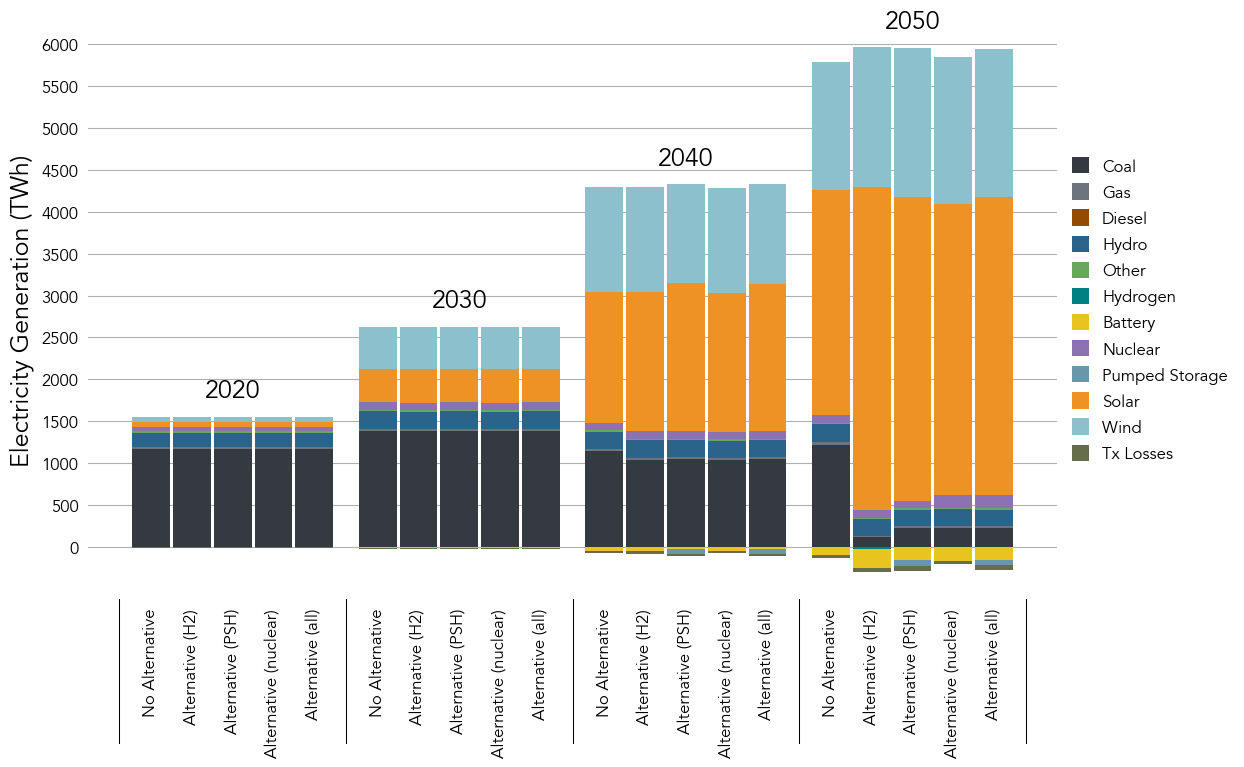

In [142]:
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_dispatch(grouped_dispatch_, scen_labels_, tech_labels_, 
               units        = 1e6, 
               units_label  = r'Electricity Generation (TWh)',
               save         = True,
               legend       = True,
               y_grid_inc   = 500,
               title        = '',
               file_name    = path_to_images + r'/group_electricity_generation.png')